In [1]:
## This notebook is demo of real panoptic segmentation, trained on cityscapes dataset

In [3]:
## installing dependencies
%%shell
git clone https://github.com/pushkar-khetrapal/realtime_panoptic.git
wget https://wallup.net/wp-content/uploads/2016/01/256862-car-landscape-vehicle-road.jpg
wget https://tri-ml-public.s3.amazonaws.com/github/realtime_panoptic/models/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth
pip uninstall -y apex
git clone https://www.github.com/nvidia/apex
cd apex
python setup.py install
pip install yacs
mv '/content/realtime_panoptic/realtime_panoptic' '/usr/local/lib/python3.6/dist-packages'

fatal: destination path 'realtime_panoptic' already exists and is not an empty directory.
--2020-08-21 09:36:04--  https://wallup.net/wp-content/uploads/2016/01/256862-car-landscape-vehicle-road.jpg
Resolving wallup.net (wallup.net)... 104.24.117.237, 104.24.116.237, 172.67.163.163, ...
Connecting to wallup.net (wallup.net)|104.24.117.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpg]
Saving to: ‘256862-car-landscape-vehicle-road.jpg.1’

256862-car-landscap     [      <=>           ]   1.60M  1.50MB/s    in 1.1s    

2020-08-21 09:36:06 (1.50 MB/s) - ‘256862-car-landscape-vehicle-road.jpg.1’ saved [1675401]

--2020-08-21 09:36:06--  https://tri-ml-public.s3.amazonaws.com/github/realtime_panoptic/models/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth
Resolving tri-ml-public.s3.amazonaws.com (tri-ml-public.s3.amazonaws.com)... 52.217.80.204
Connecting to tri-ml-public.s3.amazonaws.com (tri-ml-public.s3.amazonaws.com)|52.217.80.204

In [8]:
## importing libraries
import warnings
import argparse
import torch
import numpy as np
from PIL import Image
from torchvision.models.detection.image_list import ImageList
import time

from realtime_panoptic.models.rt_pano_net import RTPanoNet
from realtime_panoptic.config import cfg
import realtime_panoptic.data.panoptic_transform as P
from realtime_panoptic.utils.visualization import visualize_segmentation_image,visualize_detection_image
import matplotlib.pyplot as plt
cityscapes_colormap = np.array([
 [128,  64, 128],
 [244,  35, 232],
 [ 70,  70,  70],
 [102, 102, 156],
 [190, 153, 153],
 [153, 153, 153],
 [250 ,170,  30],
 [220, 220,   0],
 [107, 142,  35],
 [152, 251, 152],
 [ 70, 130, 180],
 [220,  20,  60],
 [255,   0,   0],
 [  0,   0, 142],
 [  0,   0,  70],
 [  0,  60, 100],
 [  0,  80, 100],
 [  0,   0, 230],
 [119,  11,  32],
 [  0,   0,   0]])

cityscapes_instance_label_name = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
warnings.filterwarnings("ignore", category=UserWarning)
cfg.merge_from_file('/content/realtime_panoptic/configs/demo_config.yaml')
cfg.model.backbone

'R-50-FPN-RETINANET'

In [5]:
## developing model
model = RTPanoNet(
    backbone=cfg.model.backbone, 
    num_classes=cfg.model.panoptic.num_classes,
    things_num_classes=cfg.model.panoptic.num_thing_classes,
    pre_nms_thresh=cfg.model.panoptic.pre_nms_thresh,
    pre_nms_top_n=cfg.model.panoptic.pre_nms_top_n,
    nms_thresh=cfg.model.panoptic.nms_thresh,
    fpn_post_nms_top_n=cfg.model.panoptic.fpn_post_nms_top_n,
    instance_id_range=cfg.model.panoptic.instance_id_range)
device = 'cuda'
model.to(device)
model.load_state_dict(torch.load('/content/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth'))

<All keys matched successfully>

In [6]:
## attach the link of image here
!wget 'https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg' 

--2020-08-21 09:36:57--  https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166289 (162K) [image/jpeg]
Saving to: ‘media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg’

media%2Fusers%2Fuse 100%[===================>] 162.39K  --.-KB/s    in 0.001s  

2020-08-21 09:36:58 (134 MB/s) - ‘media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg’ saved [166289/166289]



In [21]:
# Prepare for model inference.
model.eval()
input_image = Image.open('/content/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg')   ## change image directory here
data = {'image': input_image}
# data pre-processing
normalize_transform = P.Normalize(mean=cfg.input.pixel_mean, std=cfg.input.pixel_std, to_bgr255=cfg.input.to_bgr255)
transform = P.Compose([
    P.ToTensor(),
    normalize_transform,
])
data = transform(data)
print("Done with data preparation and model configuration.")
with torch.no_grad():
    input_image_list = ImageList([data['image'].to(device)], image_sizes=[input_image.size[::-1]])
    panoptic_result, _ = model.forward(input_image_list)
    print("Done with model inference.")
    instance_detection = [o.to('cpu') for o in panoptic_result["instance_segmentation_result"]]
    semseg_logics = [o.to('cpu') for o in panoptic_result["semantic_segmentation_result"]]
    semseg_prob = [torch.argmax(semantic_logit , dim=0) for semantic_logit in  semseg_logics]

Done with data preparation and model configuration.
Done with model inference.


Saved semantic segmentation visualization in semantic_segmentation_result.jpg


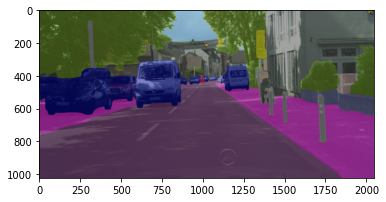

In [22]:
seg_vis = visualize_segmentation_image(semseg_prob[0], input_image, cityscapes_colormap)
Image.fromarray(seg_vis.astype('uint8')).save('semantic_segmentation_result.jpg')
print("Saved semantic segmentation visualization in semantic_segmentation_result.jpg")
plt.imshow(seg_vis)

Saved instance segmentation visualization in instance_segmentation_result.jpg


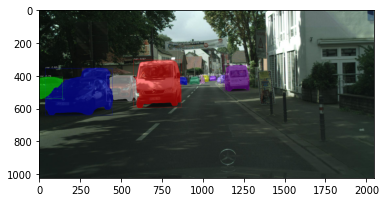

In [23]:
det_vis = visualize_detection_image(instance_detection[0], input_image, cityscapes_instance_label_name)
Image.fromarray(det_vis.astype('uint8')).save('instance_segmentation_result.jpg')
print("Saved instance segmentation visualization in instance_segmentation_result.jpg")
plt.imshow(det_vis)

/usr/local/lib/python3.6/dist-packages/realtime_panoptic/utils/panoptic_vis.py:139: RuntimeWarning: overflow encountered in exp
  z = 1/(1 + np.exp(-x))


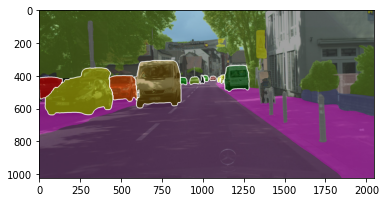

In [24]:
from realtime_panoptic.utils.panoptic_vis import panoptic_visualization
pan = panoptic_visualization(instance_detection[0], semseg_prob[0], input_image)
plt.imshow(pan)